# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [169]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams

df = pd.read_csv('zillow_data.csv')

In [130]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [131]:
#Drop RegionID
df = df.drop(columns = ['RegionID'])

In [132]:
#Drop SizeRank
df = df.drop(columns = ['SizeRank'])

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 270 entries, RegionName to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 30.3+ MB


Picking zip codes to invest in:


https://www.businessinsider.com/us-metro-area-city-best-economy-ranking-2019-8#1-san-francisco-california-the-per-capita-gdp-of-90296-and-average-weekly-wage-of-1932-were-both-by-far-the-highest-among-the-30-biggest-metro-areas-and-the-unemployment-rate-of-22-was-tied-with-austin-as-the-lowest-15

Pick top 5 from article
Then find the best zipcode to invest in each one

1. San Francisco
2. Austin
3. Seattle
4. Dallas
5. Boston

# Step 2: Data Preprocessing

In [134]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [135]:
san_fran_df = df[df['Metro'] == 'San Francisco']

In [136]:
san_fran_df.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
9,94109,San Francisco,CA,San Francisco,San Francisco,766000.0,771100.0,776500.0,781900.0,787300.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
27,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
64,94501,Alameda,CA,San Francisco,Alameda,222400.0,222300.0,222400.0,222600.0,223000.0,...,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700
76,94110,San Francisco,CA,San Francisco,San Francisco,213900.0,214800.0,216000.0,217500.0,219200.0,...,1503000,1506400,1513500,1525200,1533600,1536500,1536200,1544400,1570000,1594000
186,94536,Fremont,CA,San Francisco,Alameda,223200.0,223200.0,223300.0,223400.0,223700.0,...,960100,968200,978000,989600,1002400,1018700,1033100,1045400,1061200,1072700


In [137]:
san_fran_df.RegionName.value_counts().sum()

134

In [138]:
san_fran_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 9 to 14641
Columns: 270 entries, RegionName to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 283.7+ KB


In [139]:
san_fran_df['2018-04']

9        3813500
27        430100
64       1059700
76       1594000
186      1072700
281       658600
310       408700
333      1414800
378       994700
381       644900
429       582800
435       912300
462       986300
479      1046500
504      1033800
608       633100
615      1026600
742      4160500
896      2882100
951      1622900
1022     1417500
1069      891000
1090      688500
1107     2444200
1108      817600
1160     1667000
1256     2423800
1265     2964000
1379      675000
1383     1735200
          ...   
6945     2830100
6953      612400
6985     1352100
6999     1895600
7039     1401500
7101     1514700
7354      591500
7410     1480400
7418     1754200
7542      924900
7620      853200
7627     2003100
7651      903600
7721     1034000
7868     1386600
8589     1401100
8866      894700
8999     1635500
9306      536300
9384      999000
10008    3721100
10237    6796500
10619     977100
11547     514000
12595    1232300
12604    1278500
13144    2949400
13873     8585

How to determine what is the best zipcode in each metro area?
1. Find 3 lowest mean sale prices for the final columns 2018-4
2. Model these 3 and see if any of them has started to take off,  is easiest to predict, etc

In [140]:
#returns 3 smallest 
three_smallest_df = san_fran_df.nsmallest(3, '2018-04')

In [141]:
three_smallest_df.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
4712,94621,Oakland,CA,San Francisco,Alameda,NaN,NaN,NaN,NaN,NaN,...,363100,367400,371600,376600,381900,387400,390400,393100,399700,405500
310,94509,Antioch,CA,San Francisco,Contra Costa,142500.0,141500.0,140400.0,139300.0,138200.0,...,376000,378900,381600,385000,387500,390100,393600,397800,403500,408700
27,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100


# Step 3: EDA and Visualization

In [142]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [143]:
three_smallest_df['2013-07']

4712    168900.0
310     210500.0
27      215500.0
Name: 2013-07, dtype: float64

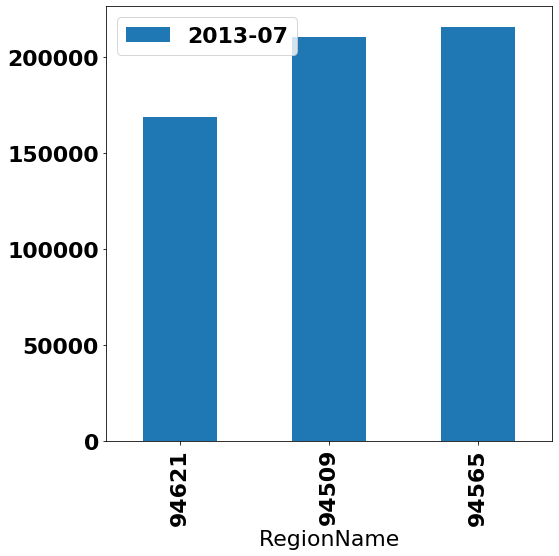

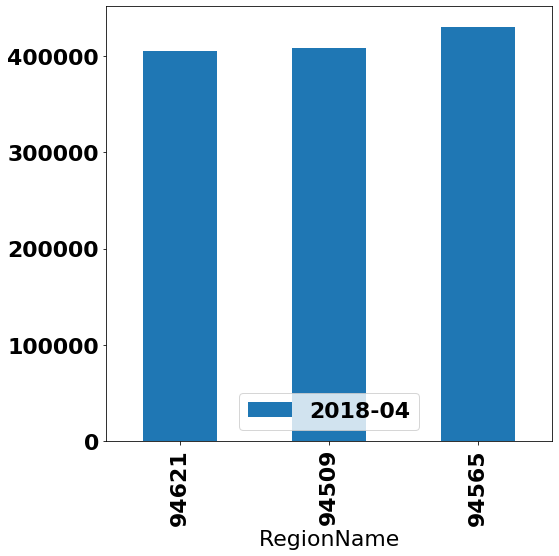

In [144]:
ax = three_smallest_df.plot.bar(x='RegionName', y='2013-07', figsize=(8,8))
ax = three_smallest_df.plot.bar(x='RegionName', y='2018-04', figsize=(8,8))

# Step 4: Reshape from Wide to Long Format

In [145]:
#delete the groupyby to have all the zipcodes and not just the mean values and dates

def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted
#     return melted.groupby('time').aggregate({'value':'mean'})

In [146]:
melted_three_smallest_df = melt_data(three_smallest_df)

In [147]:
melted_three_smallest_df.head()

,RegionName,City,State,Metro,CountyName,time,value
1,94509,Antioch,CA,San Francisco,Contra Costa,1996-04-01,142500.0
2,94565,Pittsburg,CA,San Francisco,Contra Costa,1996-04-01,139200.0
4,94509,Antioch,CA,San Francisco,Contra Costa,1996-05-01,141500.0
5,94565,Pittsburg,CA,San Francisco,Contra Costa,1996-05-01,138300.0
7,94509,Antioch,CA,San Francisco,Contra Costa,1996-06-01,140400.0


In [148]:
df1 = melted_three_smallest_df[melted_three_smallest_df['RegionName'] == 94509]

In [149]:
df1.head()

,RegionName,City,State,Metro,CountyName,time,value
1,94509,Antioch,CA,San Francisco,Contra Costa,1996-04-01,142500.0
4,94509,Antioch,CA,San Francisco,Contra Costa,1996-05-01,141500.0
7,94509,Antioch,CA,San Francisco,Contra Costa,1996-06-01,140400.0
10,94509,Antioch,CA,San Francisco,Contra Costa,1996-07-01,139300.0
13,94509,Antioch,CA,San Francisco,Contra Costa,1996-08-01,138200.0


# Step 5: ARIMA Modeling

In [150]:
df1.set_index(df1['time'], inplace=True)
df1.drop(['time'], axis=1, inplace=True)

In [151]:
df1 = df1.asfreq('MS')

In [152]:
df1.head()

,RegionName,City,State,Metro,CountyName,value
time,,,,,,
1996-04-01,94509,Antioch,CA,San Francisco,Contra Costa,142500.0
1996-05-01,94509,Antioch,CA,San Francisco,Contra Costa,141500.0
1996-06-01,94509,Antioch,CA,San Francisco,Contra Costa,140400.0
1996-07-01,94509,Antioch,CA,San Francisco,Contra Costa,139300.0
1996-08-01,94509,Antioch,CA,San Francisco,Contra Costa,138200.0


In [153]:
df1.drop(['City', 'State', 'Metro', 'CountyName', 'RegionName'], axis=1,  inplace=True)

In [154]:
df1.head()

,value
time,
1996-04-01,142500.0
1996-05-01,141500.0
1996-06-01,140400.0
1996-07-01,139300.0
1996-08-01,138200.0


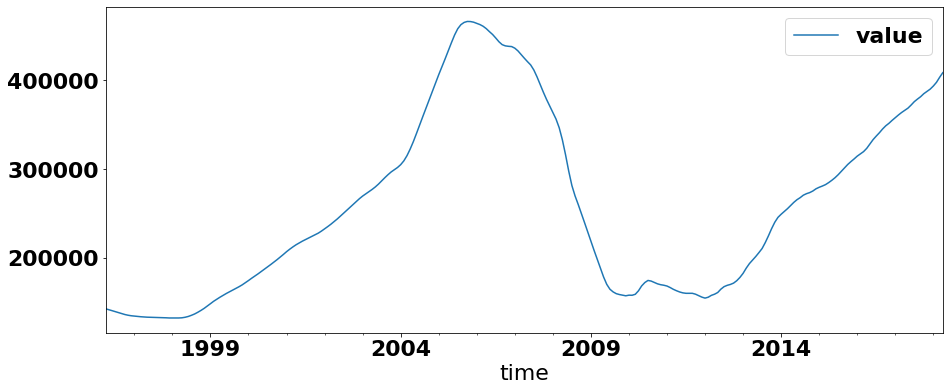

In [155]:
df1.plot(figsize=(15,6))
plt.show()

In [158]:
#define p, d, q
p = d = q = range(0, 2)

#Generate all combinations of p,d,q
pdq = list(itertools.product(p, d, q))

In [161]:
#run a grid with pdq parameters
ans = []
for comb in pdq:
    mod = sm.tsa.statespace.SARIMAX(df1, order=comb, enforce_stationarity=False,
                                    enforce_invertibility=False)
    output = mod.fit()
    ans.append([comb, output.aic])
    print('ARIMA {} : AIC Caluculated ={}'.format(comb, output.aic))

ARIMA (0, 0, 0) : AIC Caluculated =7370.425838566375
ARIMA (0, 0, 1) : AIC Caluculated =7152.136205041571
ARIMA (0, 1, 0) : AIC Caluculated =5201.016294732553
ARIMA (0, 1, 1) : AIC Caluculated =4984.426819594761
ARIMA (1, 0, 0) : AIC Caluculated =5210.710562552635
ARIMA (1, 0, 1) : AIC Caluculated =4990.384285845583
ARIMA (1, 1, 0) : AIC Caluculated =4335.141160665372
ARIMA (1, 1, 1) : AIC Caluculated =4242.462329103455


In [163]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq    (1, 1, 1)
aic      4242.46
Name: 7, dtype: object

In [164]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df1,
                                        order=(1, 1, 1),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
output = ARIMA_MODEL.fit()
print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9750      0.008    127.302      0.000       0.960       0.990
ma.L1          0.4231      0.015     27.489      0.000       0.393       0.453
sigma2      5.106e+05   2.61e+04     19.556      0.000    4.59e+05    5.62e+05


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


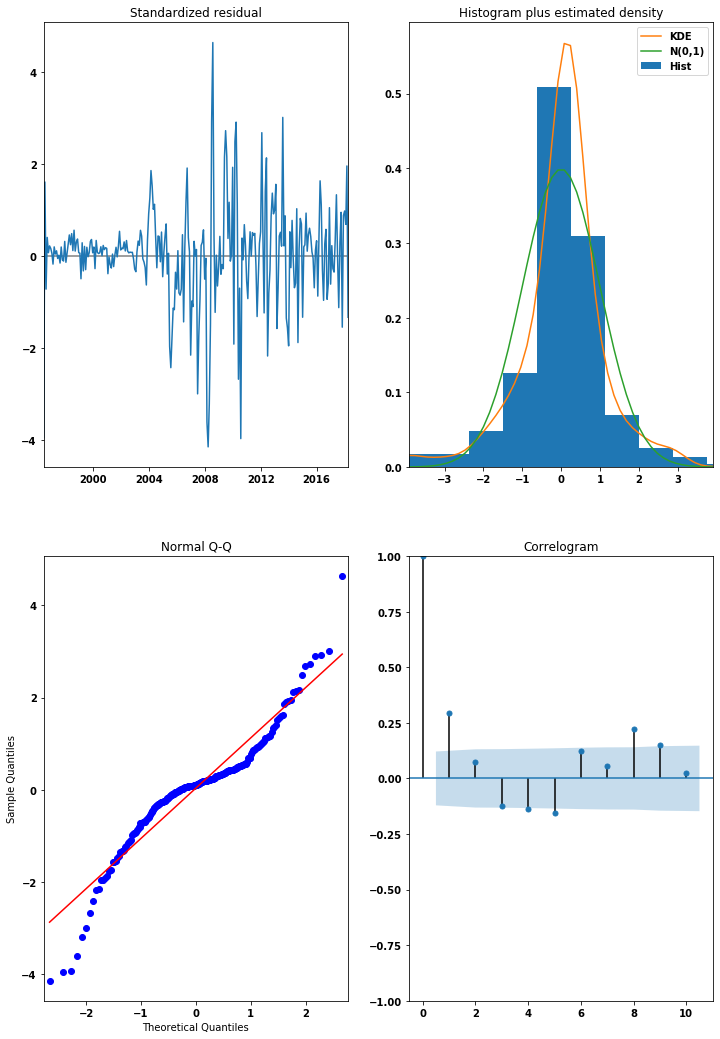

In [165]:
output.plot_diagnostics(figsize=(12,18))
plt.show()

In [166]:
#get predictions from 2017-01 to 2018-04
pred = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_conf = pred.conf_int()

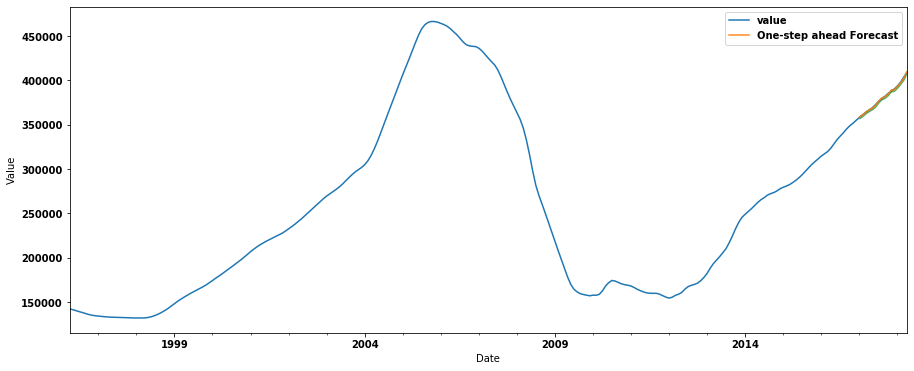

In [174]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = df1['1996':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

plt.show()

In [181]:
value_forecasted = pred.predicted_mean
value_truth = df1['1997-01-01':]

# Compute the mean square error
mse = ((value_forecasted - value_truth['value']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 476377.81


In [182]:
#dynamic forecasting
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

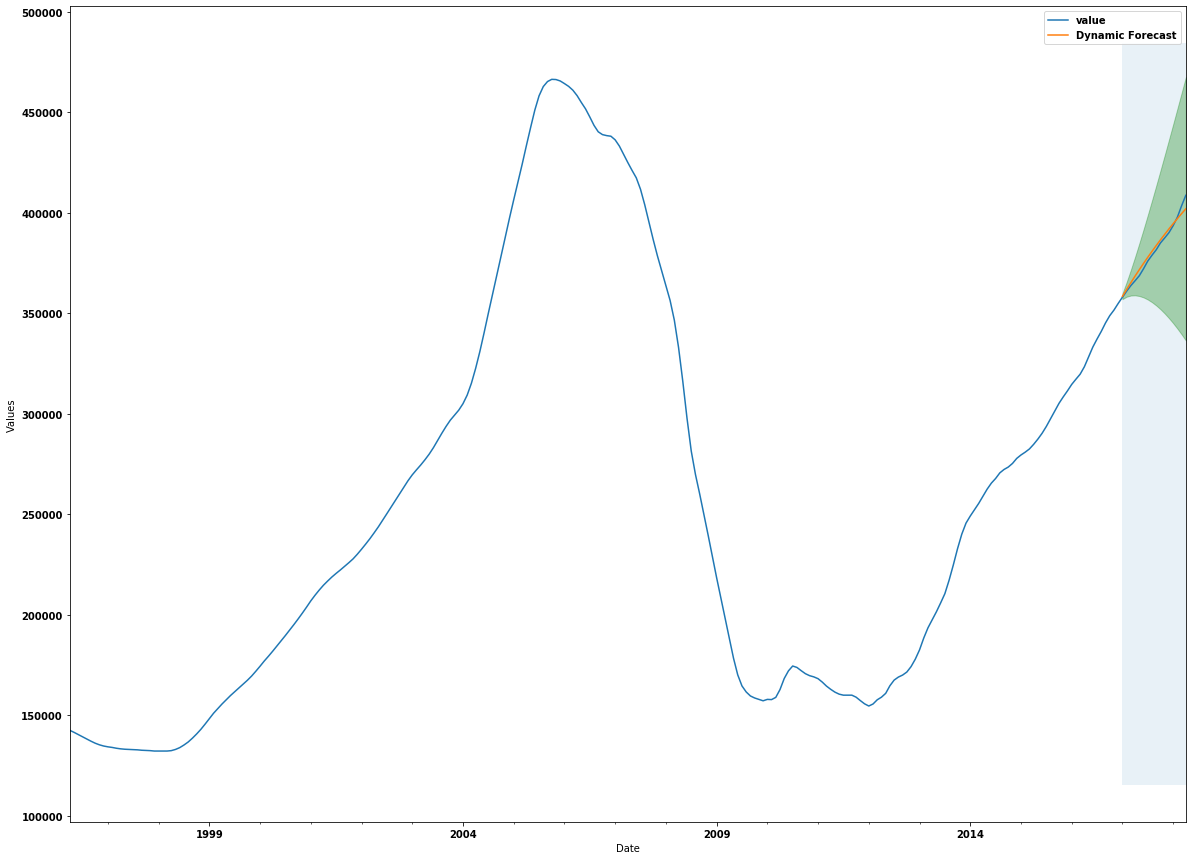

In [184]:
ax = df1['1996':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), value_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Values')

plt.legend()
plt.show()

In [185]:
value_forecasted = pred_dynamic.predicted_mean
value_truth = df1['1997-01-01':]

# Compute the mean square error
mse = ((value_forecasted - value_truth['value']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 6666430.53


In [188]:
#forecasting`
prediction = output.get_forecast(steps=100)
pred_conf = prediction.conf_int()

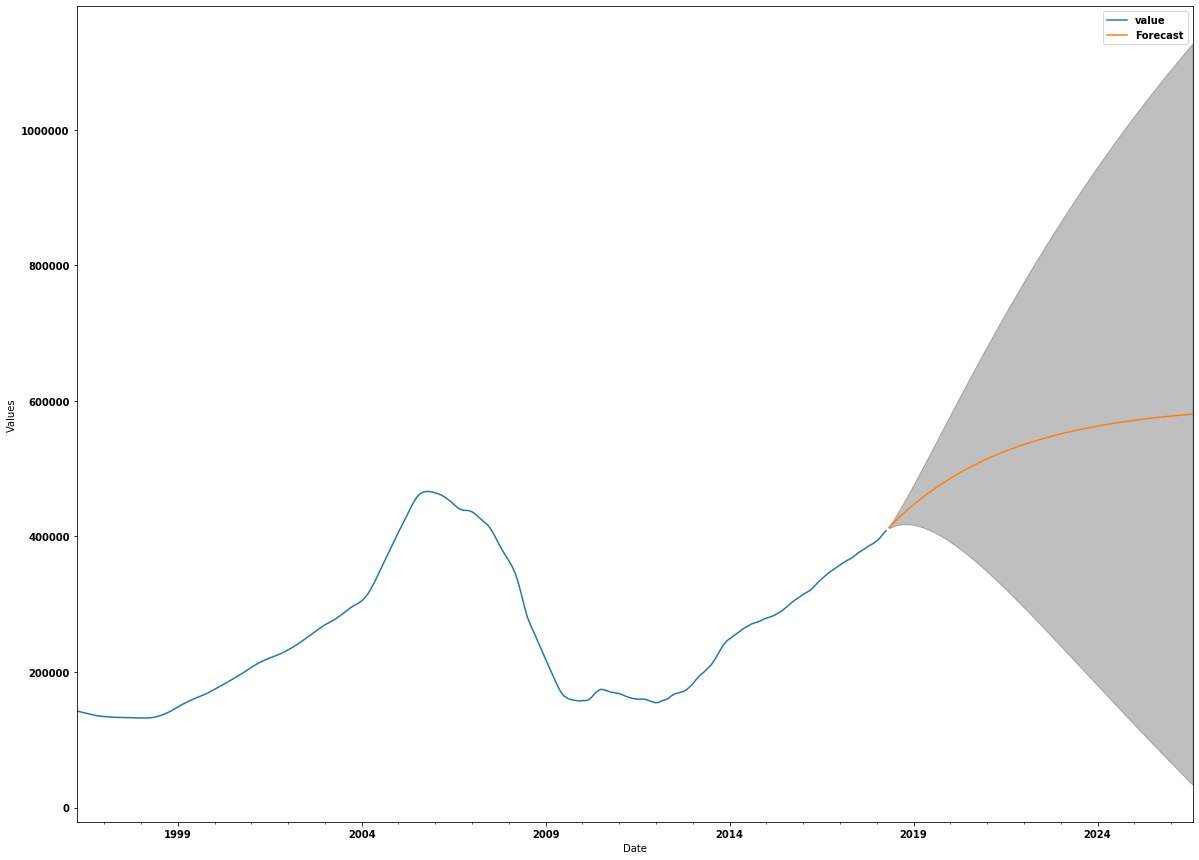

In [189]:
ax = df1.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Values')

plt.legend()
plt.show()

# Step 6: Interpreting Results